# Initial Project Analysis Pipeline
## July 2023


Brief thoughts on pipeline here:
- Gather all data
- Identify first base receives that are outs and that are not outs, and those that are just bad throws, but not received (like that play 203)

    - Other considerations here:
        - I might need to filter out throws that start too close to first for my method?
        - vertical angle?
        - velos?

- Build a probability model for this
- Make some calibration plots


From there, the path might diverge a little bit
- run expectancy?
- Fields Above Average?



### TODO:
- throw in batter x,y, velo? 
- my model grabber needs to pick the throw before whatever event!

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
import os

# Matt written files
from src.utils import *
from src.plotting import Baseball_Field
from src.game import Game

In [2]:
# pandas options
pd.set_option('display.max_columns', None)
pd.options.mode.chained_assignment = None  # default='warn'

## Prep Data

### Find throws to first that are just so bad the first baseman didn't catch it

- 203 in 1903_01_TeamNE_TeamA2 is the cannonical example

Distance between ball and player is large on average, should maybe clean up 12.199183415462679


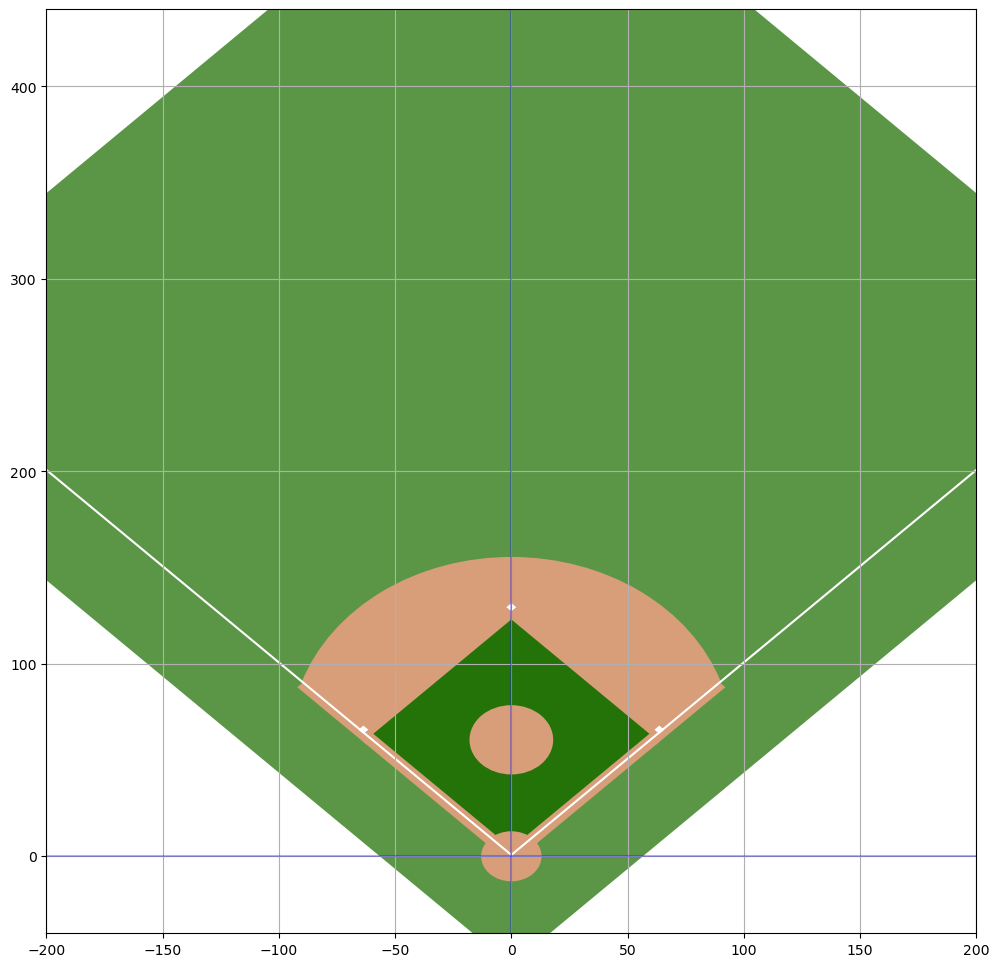

In [3]:
bf_1903_01 = Baseball_Field("1903_01_TeamNE_TeamA2")

In [4]:
game_events_1903_01 = bf_1903_01.game_obj.game_events_df.copy()
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()


game_events_1903_01.head(5)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
0,1903_01_TeamNE_TeamA2,1,1,1,19199,1,1,pitch,2.0,ball acquired,19661.0,NaN,NaN,NaN,NaN,NaN,NaN,89.076422,NaN,NaN,-2.387367,54.28680,6.37134,2.5305,-1.1700,2171
1,1903_01_TeamNE_TeamA2,1,1,1,19661,2,2,ball acquired,5.0,end of play,19661.0,1.0,pitch,19199.0,NaN,NaN,NaN,89.076422,NaN,NaN,-2.034057,-4.11549,3.61398,2.5305,-1.1700,2790
2,1903_01_TeamNE_TeamA2,1,1,1,19661,0,5,end of play,NaN,NaN,NaN,2.0,ball acquired,19661.0,NaN,NaN,NaN,89.076422,NaN,NaN,-2.034057,-4.11549,3.61398,2.5305,-1.1700,NaN
3,1903_01_TeamNE_TeamA2,2,1,2,29858,1,1,pitch,2.0,ball acquired,30320.0,NaN,NaN,NaN,NaN,NaN,NaN,89.114508,NaN,NaN,-2.288160,52.87770,6.40401,2.3136,-1.0173,2171
4,1903_01_TeamNE_TeamA2,2,1,2,30320,2,2,ball acquired,5.0,end of play,30320.0,1.0,pitch,29858.0,NaN,NaN,NaN,89.114508,NaN,NaN,-0.469218,-5.52300,0.34590,2.3136,-1.0173,2790


### Get all throws 

In [6]:
throws = game_events_1903_01.loc[game_events_1903_01["event"] == "throw (ball-in-play)", :]
throws.head(10)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y
32,1903_01_TeamNE_TeamA2,10,2,10,179315,6,3,throw (ball-in-play),2.0,ball acquired,179942.0,2.0,ball acquired,178820.0,40.970997,2.162650,63.020815,76.027923,-56.0139,116.8362,-53.716200,114.3225,3.77541,7.2063,12.6933
34,1903_01_TeamNE_TeamA2,10,2,10,180536,4,3,throw (ball-in-play),2.0,ball acquired,181361.0,2.0,ball acquired,179942.0,1.962933,2.041084,73.227697,47.089984,0.6681,129.3444,2.444979,126.2148,5.65056,29.2554,31.4652
65,1903_01_TeamNE_TeamA2,18,4,18,461301,6,3,throw (ball-in-play),2.0,ball acquired,462225.0,2.0,ball acquired,460212.0,2.714353,3.179570,75.066867,45.904246,-1.5081,145.3005,-0.552351,140.5905,4.82034,29.9541,32.4549
95,1903_01_TeamNE_TeamA2,25,6,25,616962,7,3,throw (ball-in-play),2.0,ball acquired,618777.0,2.0,ball acquired,615543.0,24.879819,17.746083,56.316458,15.056423,-141.4197,234.9465,-138.848100,234.1287,4.36419,56.8290,50.2116
109,1903_01_TeamNE_TeamA2,28,7,28,714180,6,3,throw (ball-in-play),2.0,ball acquired,714840.0,2.0,ball acquired,713652.0,59.036393,1.662283,35.729095,53.972154,-28.8978,113.7537,-27.557250,109.6296,5.30967,26.5332,24.4464
137,1903_01_TeamNE_TeamA2,36,8,36,1016790,9,3,throw (ball-in-play),16.0,ball bounce,1018407.0,2.0,ball acquired,1013886.0,19.781893,7.826560,59.497665,21.427403,36.3627,250.9065,34.939200,253.1502,6.06315,54.5067,83.0232
149,1903_01_TeamNE_TeamA2,38,9,38,1094175,5,3,throw (ball-in-play),2.0,ball acquired,1095198.0,2.0,ball acquired,1092459.0,1.108531,1.218903,84.224138,60.608922,-59.9457,81.2073,-53.675100,77.8668,6.21342,20.2293,21.3432
215,1903_01_TeamNE_TeamA2,58,13,58,1618117,6,3,throw (ball-in-play),2.0,ball acquired,1619239.0,2.0,ball acquired,1616896.0,2.358087,4.034777,72.686062,51.954068,-39.4440,125.9001,-35.535300,121.1655,5.69469,26.6307,27.1764
255,1903_01_TeamNE_TeamA2,69,16,69,2010520,8,3,throw (ball-in-play),2.0,ball acquired,2012434.0,2.0,ball acquired,2009662.0,34.124119,18.471341,51.546902,5.490810,54.4110,239.0079,55.509000,236.3835,6.40218,61.1067,68.5113
272,1903_01_TeamNE_TeamA2,73,17,73,2191492,5,3,throw (ball-in-play),2.0,ball acquired,2192317.0,2.0,ball acquired,2190634.0,48.628686,2.317024,73.219675,55.609675,-57.3255,61.6473,-56.929200,60.3264,6.11313,23.7630,24.8802


#### Find all of the throws to first that are outs

In [7]:
trusted_first_base_outs_plays = game_events_1903_01.loc[
    (game_events_1903_01["event"] == "ball acquired") &\
    (game_events_1903_01["player_position"] == 3) &\
    (game_events_1903_01["prev_event"] != "pickoff throw") &\
    (game_events_1903_01["play_per_game"].isin(game_info_1903_01.loc[(game_info_1903_01["this_play_outs"] >= 1)
                                                                     &\
                                                         (game_info_1903_01["trust_this_half"] == 1), "play_per_game"].values))
    , "play_per_game"
]

trusted_first_base_outs_plays

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y
35,1903_01_TeamNE_TeamA2,10,2,10,181361,3,2,ball acquired,5.0,end of play,182450.0,3.0,throw (ball-in-play),180536.0,NaN,NaN,NaN,23.812321,NaN,NaN,61.6866,65.9577,2.751036,45.9588,47.6892
181,1903_01_TeamNE_TeamA2,48,11,48,1376457,3,2,ball acquired,5.0,end of play,1377843.0,4.0,ball hit into play,1370550.0,NaN,NaN,NaN,5.415868,NaN,NaN,98.3451,97.2681,5.771700,61.8519,58.5273
216,1903_01_TeamNE_TeamA2,58,13,58,1619239,3,2,ball acquired,5.0,end of play,1620295.0,3.0,throw (ball-in-play),1618117.0,NaN,NaN,NaN,23.276346,NaN,NaN,59.6838,65.3253,2.773476,47.2962,47.0661
455,1903_01_TeamNE_TeamA2,119,30,119,3796416,3,2,ball acquired,5.0,end of play,3797835.0,3.0,throw (ball-in-play),3795327.0,NaN,NaN,NaN,27.688541,NaN,NaN,61.2504,67.7586,3.642990,43.5060,44.6319
484,1903_01_TeamNE_TeamA2,124,32,124,3914820,3,2,ball acquired,5.0,end of play,3916107.0,3.0,throw (ball-in-play),3913995.0,NaN,NaN,NaN,20.593925,NaN,NaN,63.9912,67.5339,4.300680,48.9084,49.2486
589,1903_01_TeamNE_TeamA2,149,39,149,4907329,3,2,ball acquired,5.0,end of play,4908055.0,3.0,throw (ball-in-play),4906405.0,NaN,NaN,NaN,2.266255,NaN,NaN,58.8330,66.2850,4.709610,61.6044,62.6427
718,1903_01_TeamNE_TeamA2,185,47,185,6121961,3,2,ball acquired,5.0,end of play,6122951.0,3.0,throw (ball-in-play),6121268.0,NaN,NaN,NaN,21.603012,NaN,NaN,59.3652,62.8815,6.934410,48.4122,48.3159
858,1903_01_TeamNE_TeamA2,223,58,224,7275642,3,2,ball acquired,5.0,end of play,7276500.0,3.0,throw (ball-in-play),7275147.0,NaN,NaN,NaN,20.634997,NaN,NaN,60.6081,67.4022,1.922883,48.4140,49.7118
907,1903_01_TeamNE_TeamA2,234,61,235,7713388,3,2,ball acquired,5.0,end of play,7714114.0,3.0,throw (ball-in-play),7712431.0,NaN,NaN,NaN,28.886532,NaN,NaN,64.6722,60.0243,5.423790,43.9923,42.4638
1017,1903_01_TeamNE_TeamA2,260,68,261,8669663,3,2,ball acquired,5.0,end of play,8670488.0,3.0,throw (ball-in-play),8668772.0,NaN,NaN,NaN,35.067428,NaN,NaN,61.6743,65.0712,2.361351,39.2451,38.4477


In [ ]:
game_events_1903_01.loc[(game_events_1903_01["event"] == "throw (ball-in-play)") &\
                        (game_events_1903_01["play_per_game"].isin(trusted_first_base_outs_plays.values)), :]

In [ ]:
bf_1903_01.clear_plot()

play_id = bf_1903_01.game_obj.get_pid_from_ppg(224)

#bf_1903_01.plot_all_components(play_id=play_id)
#bf_1903_01.fig
bf_1903_01.create_gif(play_id=play_id, tag="--1-3 out")

In [ ]:
trusted_first_base_not_outs_plays = game_events_1903_01.loc[
    (game_events_1903_01["event"] == "ball acquired") &\
    (game_events_1903_01["player_position"] == 3) &\
    (game_events_1903_01["prev_event"] != "pickoff throw") &\
    (game_events_1903_01["play_per_game"].isin(game_info_1903_01.loc[(game_info_1903_01["this_play_outs"] == 0) 
                                                                     #& (game_info_1903_01["trust_this_half"] == 1)
                                                                     ,
                                                                     "play_per_game"].values))
    , "play_per_game"
]

trusted_first_base_not_outs_plays

In [ ]:
throws.loc[throws["xy_throw_angle"] < 7]

In [ ]:
## HMM can I use the game info here?
# I think I can use just the trusted plays?
game_info_1903_01.loc[
    (game_info_1903_01["play_per_game"].isin(throws.loc[throws["xy_throw_angle"] < 7, "play_per_game"].values)) &
    (game_info_1903_01["this_play_outs"] == 0) &
    (game_info_1903_01["trust_this_play"] == 1)
    ,
    :
]


In [ ]:
game_info_1903_01.loc[
    (game_info_1903_01["play_per_game"].isin(throws.loc[(throws["xy_throw_angle"] < 7) &
                                                        (throws["player_position"].isin([1, 2, 4, 5, 6]))
                                                        , "play_per_game"].values)) &
    (game_info_1903_01["this_play_outs"] > 0) &
    (game_info_1903_01["trust_this_play"] == 1)
    ,
    :
]

In [ ]:
# NEED TO PICK THE CORRECT THROW -- do this by picking the min xy_angle?
# also need to make sure that they aren't back picks


In [ ]:
player_pos_1903_01 = bf_1903_01.game_obj.new_player_pos.copy()
player_pos_1903_01.head(3)

In [ ]:
ball_pos_1903_01 = bf_1903_01.game_obj.new_ball_pos.copy()
ball_pos_1903_01.head(3)

In [ ]:
temp_throw = throws[throws["play_id"] == 203]
temp_throw

In [ ]:
# get batter dist to first at time of throw!
ball_pos_df = ball_pos_1903_01

timestamp = temp_throw["timestamp"].values[0]

# find the x, y pos of the batter at the time of throw
# player pos and velo
batter_data = player_pos_1903_01.loc[(player_pos_1903_01["timestamp"] == timestamp) &\
                                     (player_pos_1903_01["player_position"] == 10)
                                     , ["play_id", "field_x", "field_y", "velo_x", "velo_y"]]


target_point = np.array([63.63961031, 63.63961031])

batter_pos_at_throw = batter_data[["field_x", "field_y"]].values[0]

batter_vect_to_first = (target_point - batter_pos_at_throw)

# find the distance of the batter to first
batter_dist_to_first = np.sqrt(batter_vect_to_first.dot(batter_vect_to_first))

# batter_dist_to_first

"""
# get batter velo over the whole time before the throw!
# velo is harder because I don't necessarily know when the batter starts to go
# its not at the pitch, it could be when the ball is hit, but the ball isn't
# always hit! Maybe the first event after the pitch?

batter_dist_from_home = np.sqrt(batter_pos_at_throw.dot(batter_pos_at_throw))

game_events_1903_01.loc[
    game_events_1903_01["play_id"] == temp_throw["play_id"].values[0]
].groupby("play_id").first()["timestamp"].values[0]
"""

In [ ]:
game_events_1903_01.loc[
    game_events_1903_01["play_id"] == temp_throw["play_id"].values[0]
].groupby("play_id").first()["timestamp"].values[0]

In [ ]:
temp_throw.timestamp

In [ ]:
# turn the 

In [ ]:
# player pos and velo
player_pos_1903_01.loc[(player_pos_1903_01["timestamp"] == timestamp) &\
                       (player_pos_1903_01["player_position"] == temp_throw["player_position"].values[0])
                       , ["play_id", "field_x", "field_y", "velo_x", "velo_y"]]

In [ ]:
# calculate the angle of elevation
# I think this is literally just PI - arccos(z_comp_of_velo) 

ball_pos_df = ball_pos_1903_01

timestamp = temp_throw["timestamp"].values[0]

buffer_ms = -10
snapshot_time = 250

# find when the ball is in the air with a buffer or not
ball_in_air_df = ball_pos_df.loc[(ball_pos_df["timestamp"] >= (timestamp - buffer_ms)) &\
                                   (ball_pos_df["timestamp"] <= (timestamp + snapshot_time)),
                                   # (ball_pos_1903_01["timestamp"] <= temp_throws["next_event_ts"].values[0] + buffer_ms), # this is for the whole throw
                                   :
                                  ] 

In [ ]:
throw_velo_vect = ball_in_air_df[["ball_position_x", "ball_position_y", "ball_position_z"]].iloc[-1].values \
    - ball_in_air_df[["ball_position_x", "ball_position_y", "ball_position_z"]].iloc[0].values
#throw_velo_vect

ball_flight_time_sec = (ball_in_air_df["timestamp"].iloc[-1] - ball_in_air_df["timestamp"].iloc[0])/1000

unit_z_vect = np.array([0, 0, 1])


elevation_angle_rad = (np.pi/2 - np.arccos(throw_velo_vect.dot(unit_z_vect) / np.sqrt(throw_velo_vect.dot(throw_velo_vect))))
elevation_angle_deg = elevation_angle_rad * 180 / np.pi
elevation_angle_deg

# this is feet per (ball_flight_time) * 1.467 [fps to mph]
np.sqrt(throw_velo_vect.dot(throw_velo_vect)) / ball_flight_time_sec


In [ ]:
def compute_throw_angle(a, target_point = np.array([63.63961031, 63.63961031])):
    """
    target_point defaults to first base
    
    """
    
    # TODO: do I NEED THE angle of inclination even here?
    # I think not for now!
        
    # make a vector from the first point to the target point
    xy_vect_to_target = target_point - a[["ball_position_x", "ball_position_y"]].iloc[0].values

    # scale it to be a unit vector
    unit_xy_vect_to_target = xy_vect_to_target / np.sqrt(xy_vect_to_target.dot(xy_vect_to_target))
    
    # Maybe the whole window so we don't get noise?
    throw_velo_xy_vect = a[["ball_position_x", "ball_position_y"]].iloc[-1].values \
        - a[["ball_position_x", "ball_position_y"]].iloc[0].values
    
    # the other one is a unit vect, so we don't need to divide here
    xy_angle_to_first_rad = np.arccos(throw_velo_xy_vect.dot(unit_xy_vect_to_target) / np.sqrt(throw_velo_xy_vect.dot(throw_velo_xy_vect)))
    
    xy_angle_to_first_deg = xy_angle_to_first_rad * 180 / np.pi

    # hmm there are some times where you might want to miss the bag -- e.g. throws from catcher! 

    return xy_angle_to_first_deg
    
    

In [ ]:
def fill_throw_angle(timestamp, ball_pos_df, target_point = np.array([63.63961031, 63.63961031])): 
    """
    
    """
    
    ball_pos_df = ball_pos_df.copy()
    
    buffer_ms = -10
    snapshot_time = 250

    # find when the ball is in the air with a buffer or not
    ball_in_air_df = ball_pos_df.loc[(ball_pos_df["timestamp"] >= (timestamp - buffer_ms)) &\
                                       (ball_pos_df["timestamp"] <= (timestamp + snapshot_time)),
                                       # (ball_pos_1903_01["timestamp"] <= temp_throws["next_event_ts"].values[0] + buffer_ms), # this is for the whole throw
                                       :
                                      ] 
    
    # print(ball_in_air_df["play_id"].describe())
    angle = compute_throw_angle(ball_in_air_df, target_point)
    
    return angle
    
    
    

In [ ]:
# Find plays where there is a throw and no ball acquired before the end of the play
# these are throwing errors, but we can't guarantee that they are thrown to first yet

game_events_1903_01.loc[(game_events_1903_01["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
                        (game_events_1903_01["next_event"] == "end of play")
                        # I have the angle already!
                        # need another condition that says this is going to first?
                        
                        , :]

In [ ]:
throws["xy_throw_angle"] = np.nan
throws["xy_throw_angle"] = throws.apply(lambda row: fill_throw_angle(row["timestamp"], ball_pos_1903_01), axis = 1)

In [ ]:
throws["xy_throw_angle"].loc[(throws["player_position"].isin([1, 2, 4, 5, 6]))].plot(kind="hist")

In [ ]:
# because this is like the cosine similarity to each other, we don't have a sense for which side of the bag the throw went to
# want infielder throws only
# note that higher angles throws are either throws behind a runner (usually in the [5, 10] range)
# or they are bad throws?

throws.loc[(throws["xy_throw_angle"] > 100) & (throws["player_position"].isin([1, 2, 4, 5, 6]) ), :]

In [ ]:
# look at all of these with the outs

In [ ]:
game_info_1903_01 = bf_1903_01.game_obj.game_info_df.copy()

In [ ]:
game_info_1903_01.loc[game_info_1903_01["play_per_game"] == 124]

game_info_1903_01.loc[(game_info_1903_01["inning"] == 4) & (game_info_1903_01["top_bottom_inning"] == "Top")]

In [ ]:
bf_1903_01.clear_plot()

play_id = 25 # throws.loc[throws["xy_throw_angle"] < 5, :].play_id.iloc[1] # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf_1903_01.plot_all_components(play_id=play_id)
bf_1903_01.fig

# bf_1903_01.create_gif(play_id=play_id, tag="--4-6-3 dp")

In [ ]:
throws[["xy_throw_angle", "elevation_throw_angle", "throw_velo"]].describe()

In [ ]:
throws[["xy_throw_angle", "elevation_throw_angle", "throw_velo"]].plot(kind="hist", alpha=0.5)

### the method I have below pulls the end play, but I want the last throw before that!

In [71]:
bf = Baseball_Field("1902_25_TeamMH_TeamA3")
g = bf.game_obj
g_game_info = g.game_info_df.copy()
g_game_events = g.game_events_df.copy()

In [84]:
trusted_successful_first_base_outs_plays = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] >= 1) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , "play_per_game"
    ]

In [85]:
trusted_successful_first_base_outs_plays

33       12
263      80
295      88
335      99
610     170
659     181
910     249
998     275
1188    326
Name: play_per_game, dtype: int64

In [86]:
g_game_events.loc[
    (g_game_events["play_per_game"].isin(trusted_successful_first_base_outs_plays.values)) &
    (g_game_events["event"] == "throw (ball-in-play)")
].groupby("play_per_game").last()

,game_str,play_id,at_bat,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y
play_per_game,,,,,,,,,,,,,,,,,,,
80,1902_25_TeamMH_TeamA3,79,20.0,2444212,5,3,throw (ball-in-play),2.0,ball acquired,2444962.0,2.0,ball acquired,2443512.0,2.491820,-0.084918,77.544512,32.975824,-14.9730,27.7920
88,1902_25_TeamMH_TeamA3,87,21.0,2606462,5,3,throw (ball-in-play),2.0,ball acquired,2607462.0,2.0,ball acquired,2605012.0,2.454529,2.638689,77.284232,46.759101,-46.3131,92.2386
170,1902_25_TeamMH_TeamA3,169,42.0,5465212,5,3,throw (ball-in-play),2.0,ball acquired,5466312.0,2.0,ball acquired,5463612.0,4.565915,3.208294,75.142339,47.364506,-54.8901,88.4364
249,1902_25_TeamMH_TeamA3,248,61.0,8107997,1,3,throw (ball-in-play),2.0,ball acquired,8108997.0,2.0,ball acquired,8106447.0,4.205651,21.373355,23.795683,55.840902,27.2151,53.7417
275,1902_25_TeamMH_TeamA3,274,66.0,8908047,2,3,throw (ball-in-play),2.0,ball acquired,8909097.0,2.0,ball acquired,8907147.0,0.359665,9.576964,48.236728,43.370616,17.8644,6.3603
326,1902_25_TeamMH_TeamA3,325,77.0,10595297,4,3,throw (ball-in-play),2.0,ball acquired,10596147.0,2.0,ball acquired,10594747.0,0.897302,5.358753,69.263296,25.381376,-0.6981,131.6634


In [89]:
bf.clear_plot()

play_id = 169 #bf.game_obj.get_pid_from_ppg(224)

#bf.plot_all_components(play_id=play_id)
#bf.fig
# bf.create_gif(play_id=play_id, tag="--5-3 out")

MovieWriter ffmpeg unavailable; using Pillow instead.


## Collect the plays into a csv, will use this to compute features later

In [91]:
all_games = get_all_game_strs()

Gathered a list of 97 games


In [92]:
# TODO! This should acutally be the throw right before this event!


total_trusted_outs = 0

# this should be a slight overcount tbh, because I will need to filter
# see issue #34, #6, etc
total_trusted_successful_first_base_outs = 0 
total_trusted_unsuccessful_first_base_outs = 0
total_throws_out_of_play = 0
total_trusted_double_plays = 0

model_dataset = pd.DataFrame()

cols_to_save = ["game_str", "play_id", "player_id", #"play_per_game",
                "player_position",
                "xy_throw_angle", "elevation_throw_angle",
                "throw_velo", "batter_dist_to_first",
                "thrower_x","thrower_y",
                "batter_x","batter_y",
                "ball_position_x", "ball_position_y", "ball_position_z",
                "type"]


for which_game in all_games:
    if which_game in ["1902_19_TeamME_TeamA2", "1902_13_TeamMD_TeamA2", "1902_03_TeamMG_TeamA3", "1901_13_TeamLL_TeamB",
                     "1902_18_TeamMB_TeamA1", "1900_02_TeamKJ_TeamB", "1901_06_TeamLI_TeamA3", "1902_27_TeamMH_TeamA3",
                     "1902_13_TeamMK_TeamB", "1903_27_TeamNH_TeamA3", "1902_07_TeamMJ_TeamB", "1902_20_TeamME_TeamA2",
                     "1902_30_TeamMF_TeamA2", "1901_05_TeamLI_TeamA3", "1901_17_TeamLH_TeamA3", "1902_21_TeamME_TeamA2",
                     ""]:
        continue
    
    print("Which game: {}".format(which_game))

    bf = Baseball_Field(which_game)
    g = bf.game_obj
    g_game_info = g.game_info_df.copy()
    g_game_events = g.game_events_df.copy()
    
    trusted_outs = g_game_info.loc[(g_game_info["this_play_outs"] > 0) & (g_game_info["trust_this_half"] == 1), :]
    
    trusted_outs["type"] = "trusted_out"
    model_dataset = pd.concat([model_dataset, trusted_outs[["game_str", "play_per_game", "type"]]])
    trusted_outs = trusted_outs.shape[0]
    
    # NOTE: WILL DEAL WITH FILTERING 
    
    # find the plays that are outs, that we trust, and end with the first baseman
    trusted_successful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] >= 1) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ]
    
    # get the last throw! (I am assuming this is a throw to first because it end with first!)
    trusted_successful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_successful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_successful_first_base_outs_throws["type"] = "trusted_first_base_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_throws[cols_to_save]])
    trusted_successful_first_base_outs_throws = trusted_successful_first_base_outs_throws.shape[0]
    
    
    trusted_successful_first_base_outs_receives["type"] = "trusted_first_base_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_successful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_receives = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 0) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , :
    ]
    
    trusted_unsuccessful_first_base_outs_receives["type"] = "trusted_first_base_not_out_receives"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_receives[cols_to_save]])
    
    trusted_unsuccessful_first_base_outs_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_unsuccessful_first_base_outs_receives["play_per_game"].values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    trusted_unsuccessful_first_base_outs_throws["type"] = "trusted_first_base_not_out_throws"
    model_dataset = pd.concat([model_dataset, trusted_unsuccessful_first_base_outs_throws[cols_to_save]])
    trusted_unsuccessful_first_base_outs_throws = trusted_unsuccessful_first_base_outs_throws.shape[0]

    
    trusted_double_plays = g_game_events.loc[
        (g_game_events["event"] == "ball acquired") &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["player_position"] == 3) &\
        (g_game_events["prev_event"] != "pickoff throw") &\
        (g_game_events["play_per_game"].isin(g_game_info.loc[(g_game_info["this_play_outs"] == 2) &\
                                                             (g_game_info["trust_this_half"] == 1), "play_per_game"].values))
        , "play_per_game"
    ]
    
    # I think I want all throws! there should be some overlap here! 
    trusted_double_plays_throws = g_game_events.loc[
        (g_game_events["play_per_game"].isin(trusted_double_plays.values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ]#.groupby("play_per_game").last()
    
    trusted_double_plays_throws["type"] = "trusted_double_play"
    model_dataset = pd.concat([model_dataset, trusted_double_plays_throws[cols_to_save]])
    trusted_double_plays_throws = trusted_double_plays_throws.shape[0]

    
    # TODO: Add overthrows here!
    throws_out_of_play = g_game_events.loc[
        (g_game_events["event"].isin(["ball bounce", "throw (ball-in-play)"])) &\
        (g_game_events["next_event"] == "end of play") &\
        (g_game_events["xy_throw_angle"] <= 10)
        , "play_per_game"
    ]
    
    throws_out_of_play = g_game_events.loc[
        (g_game_events["play_per_game"].isin(throws_out_of_play.values)) &
        (g_game_events["event"] == "throw (ball-in-play)")
    ].groupby("play_per_game").last()
    
    throws_out_of_play["type"] = "throws_to_end_play"
    model_dataset = pd.concat([model_dataset, throws_out_of_play[cols_to_save]])
    throws_out_of_play = throws_out_of_play.shape[0]    
    
    print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {} \t throws to end play {}\n".format(
        trusted_outs,
        trusted_successful_first_base_outs_throws,
        trusted_unsuccessful_first_base_outs_throws,
        trusted_double_plays_throws,
        throws_out_of_play
    ))
    
    
    total_trusted_outs += trusted_outs
    total_trusted_successful_first_base_outs += trusted_successful_first_base_outs_throws
    total_trusted_unsuccessful_first_base_outs += trusted_unsuccessful_first_base_outs_throws
    total_trusted_double_plays += trusted_double_plays_throws
    total_throws_out_of_play += throws_out_of_play
    
    plt.close()

    
print("---------------")    

print("{} trusted outs in this game \n{} trusted first base outs\t{} trusted_first_base_not_outs --- \t trusted double plays {} \t throws to end play {}\n".format(
    total_trusted_outs,
    total_trusted_successful_first_base_outs,
    total_trusted_unsuccessful_first_base_outs,
    total_trusted_double_plays,
    total_throws_out_of_play
    
))


Which game: 1903_01_TeamNE_TeamA2
Distance between ball and player is large on average, should maybe clean up 12.199183415462679
31 trusted outs in this game 
9 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1903_16_TeamNI_TeamA3
41 trusted outs in this game 
9 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1902_02_TeamMG_TeamA3
33 trusted outs in this game 
10 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_08_TeamNJ_TeamB
39 trusted outs in this game 
13 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1900_08_TeamKL_TeamB
12 trusted outs in this game 
4 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_23_TeamNA_TeamA1
32 tru

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


12 trusted outs in this game 
4 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_17_TeamNI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


28 trusted outs in this game 
9 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_27_TeamNK_TeamB
36 trusted outs in this game 
5 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1901_12_TeamLJ_TeamB
12 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1900_09_TeamKK_TeamB
3 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_01_TeamLG_TeamA3
9 trusted outs in this game 
1 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1900_03_TeamKJ_TeamB
Distance between ball and player is large on average, should maybe clean up 6.403561421830762
6 trusted outs in this game 
0 trusted first ba

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


9 trusted outs in this game 
2 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_32_TeamNB_TeamA1
33 trusted outs in this game 
11 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 3 	 throws to end play 0

Which game: 1901_07_TeamLK_TeamB
9 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_23_TeamMA_TeamA1
31 trusted outs in this game 
7 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 3 	 throws to end play 0

Which game: 1902_15_TeamMK_TeamB
39 trusted outs in this game 
11 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 3 	 throws to end play 0

Which game: 1902_04_TeamML_TeamB
31 trusted outs in this game 
8 trusted first base outs	4 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


41 trusted outs in this game 
12 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_19_TeamNL_TeamB
37 trusted outs in this game 
11 trusted first base outs	4 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1901_02_TeamLG_TeamA3
5 trusted outs in this game 
2 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_31_TeamNB_TeamA1


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


38 trusted outs in this game 
8 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_09_TeamLK_TeamB
9 trusted outs in this game 
0 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_10_TeamMI_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


12 trusted outs in this game 
0 trusted first base outs	3 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_02_TeamNE_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


29 trusted outs in this game 
12 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1902_26_TeamMC_TeamA1
0 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_26_TeamNK_TeamB
32 trusted outs in this game 
8 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1902_24_TeamMA_TeamA1
36 trusted outs in this game 
11 trusted first base outs	5 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_01_TeamMG_TeamA3
24 trusted outs in this game 
5 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_18_TeamLH_TeamA3
0 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


9 trusted outs in this game 
2 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_30_TeamNB_TeamA1
36 trusted outs in this game 
16 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_11_TeamMI_TeamA3
39 trusted outs in this game 
8 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_05_TeamND_TeamA2
Distance between ball and player is large on average, should maybe clean up 14.67974023000007
35 trusted outs in this game 
6 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1903_26_TeamNH_TeamA3
34 trusted outs in this game 
9 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1903_15_TeamNG_TeamA3


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


38 trusted outs in this game 
11 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1900_04_TeamKK_TeamB
12 trusted outs in this game 
1 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1903_20_TeamNL_TeamB
37 trusted outs in this game 
14 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1902_06_TeamML_TeamB
23 trusted outs in this game 
6 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1903_18_TeamNI_TeamA3
46 trusted outs in this game 
16 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1902_09_TeamMJ_TeamB
47 trusted outs in this game 
6 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encount

36 trusted outs in this game 
7 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_29_TeamMF_TeamA2


/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


16 trusted outs in this game 
6 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1902_28_TeamMC_TeamA1
15 trusted outs in this game 
4 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_04_TeamLI_TeamA3
19 trusted outs in this game 
5 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 4 	 throws to end play 0

Which game: 1903_28_TeamNF_TeamA2
48 trusted outs in this game 
5 trusted first base outs	1 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1901_16_TeamLH_TeamA3
12 trusted outs in this game 
0 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_25_TeamMH_TeamA3
41 trusted outs in this game 
6 trusted first base outs	4 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq
/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


21 trusted outs in this game 
7 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_17_TeamMB_TeamA1
15 trusted outs in this game 
2 trusted first base outs	4 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_08_TeamMJ_TeamB
40 trusted outs in this game 
11 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1903_10_TeamNJ_TeamB
38 trusted outs in this game 
10 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 3 	 throws to end play 0

Which game: 1903_29_TeamNF_TeamA2
41 trusted outs in this game 
11 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 1 	 throws to end play 0

Which game: 1901_15_TeamLL_TeamB
Distance between ball and player is large on average, should maybe clean up 5.3524560073690175
15 trusted outs in this game 
2 trusted 

/Users/mattnicholson/Documents/RandomProjects/smt-data-challenge/src/game.py:1259: RuntimeWarning: invalid value encountered in cast
  running_outs_seq[(running_index): (running_index + outs_seq.shape[0]), :] = outs_seq


35 trusted outs in this game 
8 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 2 	 throws to end play 0

Which game: 1901_11_TeamLJ_TeamB
3 trusted outs in this game 
0 trusted first base outs	0 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

Which game: 1902_31_TeamMF_TeamA2
42 trusted outs in this game 
9 trusted first base outs	2 trusted_first_base_not_outs --- 	 trusted double plays 0 	 throws to end play 0

---------------
2219 trusted outs in this game 
537 trusted first base outs	108 trusted_first_base_not_outs --- 	 trusted double plays 88 	 throws to end play 0



In [94]:
# Write the model_dataset 
model_dataset.to_csv("model_dataset.csv")

## See some of the overthrows?

In [211]:
model_dataset = pd.read_csv("model_dataset.csv", index_col=0)

In [212]:
model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_receives"]

,game_str,play_per_game,type,play_id,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z
542,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_not_out_receives,136.0,NaN,NaN,NaN,87.755115,NaN,NaN,2.5248,0.6639,57.420900,61.7751,3.735570
658,1903_16_TeamNI_TeamA3,NaN,trusted_first_base_not_out_receives,162.0,NaN,NaN,NaN,2.910815,NaN,NaN,60.7692,63.1563,60.861300,67.8513,-1.542582
149,1902_02_TeamMG_TeamA3,NaN,trusted_first_base_not_out_receives,44.0,NaN,NaN,NaN,94.586580,NaN,NaN,-6.2472,127.3770,55.530300,142.1634,0.452622
1211,1902_02_TeamMG_TeamA3,NaN,trusted_first_base_not_out_receives,339.0,NaN,NaN,NaN,37.558614,NaN,NaN,37.5030,36.6669,24.251700,91.7796,0.000000
340,1903_08_TeamNJ_TeamB,NaN,trusted_first_base_not_out_receives,90.0,NaN,NaN,NaN,3.609238,NaN,NaN,60.6081,61.6809,64.012800,70.2018,3.706350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_receives,38.0,NaN,NaN,NaN,13.036025,NaN,NaN,53.3625,55.6197,63.756000,63.3762,3.834150
281,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_receives,78.0,NaN,NaN,NaN,89.209279,NaN,NaN,-1.0044,2.1624,54.129600,101.2713,7.114380
865,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_receives,237.0,NaN,NaN,NaN,19.564819,NaN,NaN,48.5805,51.1494,61.237200,66.3597,4.883250
998,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_not_out_receives,287.0,NaN,NaN,NaN,3.817707,NaN,NaN,61.3140,60.6120,58.423500,66.6582,2.338893


In [39]:
trusted_first_base_out = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_throws"]
trusted_first_base_not_out = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_throws"]


In [5]:
bf = Baseball_Field("1903_06_TeamND_TeamA2")

Distance between ball and player is large on average, should maybe clean up 15.614163808346984


In [6]:
g_game_events = bf.game_obj.game_events_df.copy()

In [7]:
throws = g_game_events.loc[g_game_events["event"] == "throw (ball-in-play)", :]

throws.head(10)

,game_str,play_id,at_bat,play_per_game,timestamp,player_position,event_code,event,next_event_code,next_event,next_event_ts,prev_event_code,prev_event,prev_event_ts,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,ball_position_x,ball_position_y,ball_position_z,batter_x,batter_y,player_id
40,1903_06_TeamND_TeamA2,12,3,12,228274,8,3,throw (ball-in-play),2.0,ball acquired,229624.0,2.0,ball acquired,227324.0,10.385907,6.244960,72.976509,31.150939,-65.4420,238.6455,-63.566100,239.109000,5.832390,50.5044,91.8858,1177
51,1903_06_TeamND_TeamA2,15,4,15,300774,2,3,throw (ball-in-play),2.0,ball acquired,302024.0,2.0,ball acquired,300074.0,48.408620,3.093778,75.778152,92.848374,-0.2481,-3.7899,1.263366,-1.634841,6.481920,-3.6147,-0.3735,1195
63,1903_06_TeamND_TeamA2,17,5,17,463274,6,3,throw (ball-in-play),2.0,ball acquired,464124.0,2.0,ball acquired,462524.0,1.224602,2.997335,69.148599,38.644448,-15.1536,105.5373,-14.643060,100.191300,5.535810,35.2689,37.4004,6674
77,1903_06_TeamND_TeamA2,19,6,19,530924,7,3,throw (ball-in-play),16.0,ball bounce,532674.0,2.0,ball acquired,528874.0,15.175195,10.079144,62.604666,29.162911,-203.0013,201.9747,-192.039600,195.358500,5.984460,50.4996,89.6745,5177
90,1903_06_TeamND_TeamA2,22,7,22,625324,7,3,throw (ball-in-play),2.0,ball acquired,626974.0,2.0,ball acquired,623224.0,4.750103,11.359865,55.669912,2.369563,-153.0381,202.6890,-152.502600,201.579000,6.656370,61.2846,63.3774,5177
111,1903_06_TeamND_TeamA2,26,8,26,735124,8,3,throw (ball-in-play),2.0,ball acquired,736774.0,2.0,ball acquired,733824.0,19.618751,10.398160,62.569671,13.322105,27.8679,261.8421,26.015970,260.087700,6.108210,58.0512,51.5463,8032
126,1903_06_TeamND_TeamA2,29,9,29,821874,4,3,throw (ball-in-play),2.0,ball acquired,822724.0,2.0,ball acquired,820324.0,0.877317,3.873160,70.904748,51.080418,55.7145,142.7604,53.289000,145.237500,2.916018,30.5907,24.6912,6851
153,1903_06_TeamND_TeamA2,36,11,36,1060774,6,3,throw (ball-in-play),2.0,ball acquired,1062124.0,2.0,ball acquired,1059374.0,1.348181,6.044604,80.113805,44.257551,-64.8597,131.9976,-63.221100,128.942700,5.976090,32.6205,32.0715,1972
266,1903_06_TeamND_TeamA2,68,20,70,2056524,1,3,throw (ball-in-play),2.0,ball acquired,2057074.0,2.0,ball acquired,2056274.0,6.967940,17.431326,25.505125,31.355156,39.0201,57.7122,42.349500,59.394300,1.244166,41.1927,41.7471,9464
277,1903_06_TeamND_TeamA2,71,21,73,2187224,2,3,throw (ball-in-play),2.0,ball acquired,2187974.0,2.0,ball acquired,2186474.0,92.971256,0.700019,85.014516,88.376547,-0.7137,-5.9037,-4.080810,-0.768990,5.205360,2.7708,-0.4338,9604


In [8]:
throws["player_id"].value_counts()

player_id
9464    5
1177    4
6674    4
6875    4
6851    3
1972    3
1195    2
5177    2
9604    2
1547    2
8032    1
6902    1
2480    1
Name: count, dtype: int64

In [98]:
bf.clear_plot()


In [27]:
trusted_first_base_not_out

,game_str,play_per_game,type,play_id,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z
136,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_not_out,136.0,4.043129,2.700385,72.049428,87.838535,0.4875,-4.4328,3.0078,0.0834,1.300593,-6.23205,6.054330
163,1903_16_TeamNI_TeamA3,NaN,trusted_first_base_not_out,162.0,4.058150,0.972882,68.085284,28.426292,-30.8841,55.5534,43.7955,43.2861,-28.511940,53.18820,5.461320
44,1902_02_TeamMG_TeamA3,NaN,trusted_first_base_not_out,44.0,14.460097,13.504034,81.544724,69.089809,229.6104,249.2877,21.9819,118.7580,228.510300,254.78040,1.719375
91,1903_08_TeamNJ_TeamB,NaN,trusted_first_base_not_out,90.0,5.498954,4.967871,77.104126,32.771272,-32.9721,114.2355,39.0390,41.9886,-33.565800,111.36240,4.000170
219,1903_08_TeamNJ_TeamB,NaN,trusted_first_base_not_out,218.0,2.548375,4.414598,74.465009,40.627713,-38.3232,105.1734,34.2768,35.5605,-39.951600,102.21630,4.351530
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out,24.0,3.905028,2.495060,71.768956,NaN,NaN,NaN,NaN,NaN,5.067990,19.12845,4.529010
38,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out,38.0,1.037926,5.407066,66.640980,35.784509,38.8428,137.2914,37.5894,39.1056,36.456600,135.84750,3.861210
237,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out,237.0,5.854195,17.025390,29.724053,44.351118,25.2450,53.1012,30.5565,34.1010,26.884080,55.15740,2.358609
288,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_not_out,287.0,0.671682,6.174653,76.489704,38.645421,-56.3661,139.4727,37.1307,35.5194,-53.627100,136.64520,6.388770


#### Throws to first that were outs

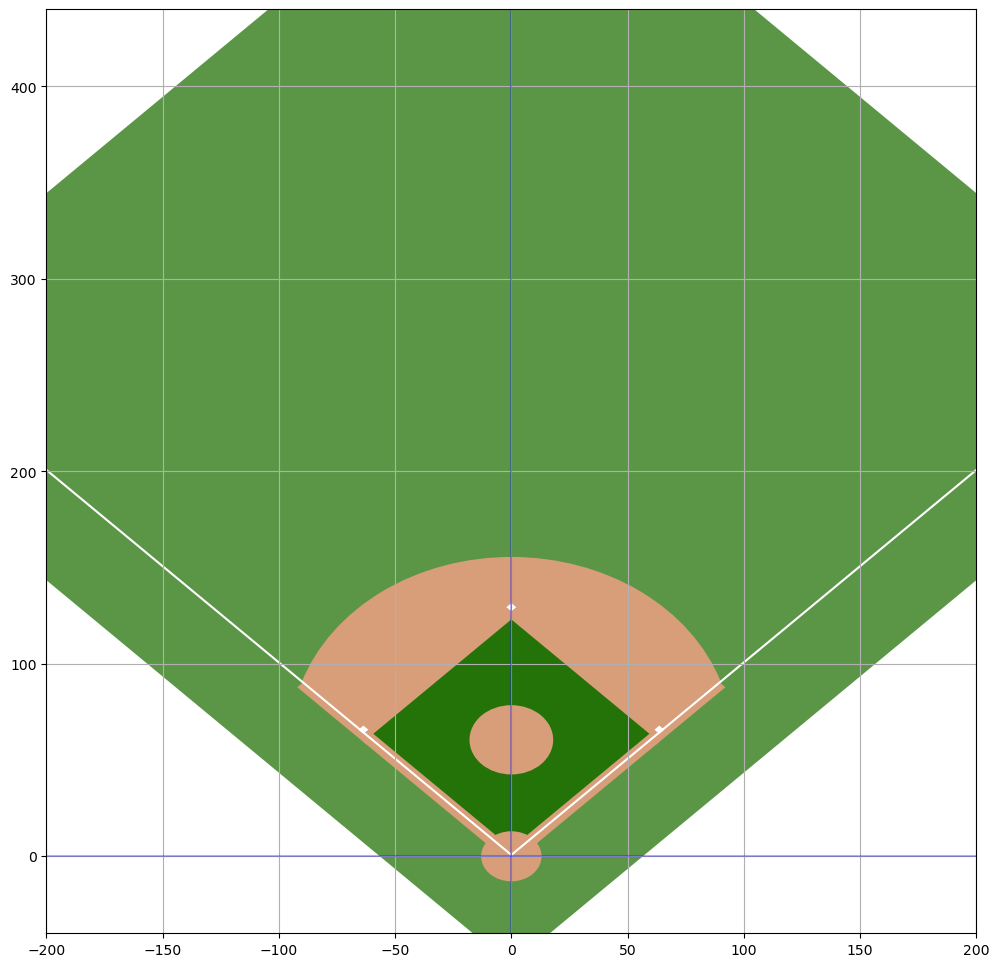

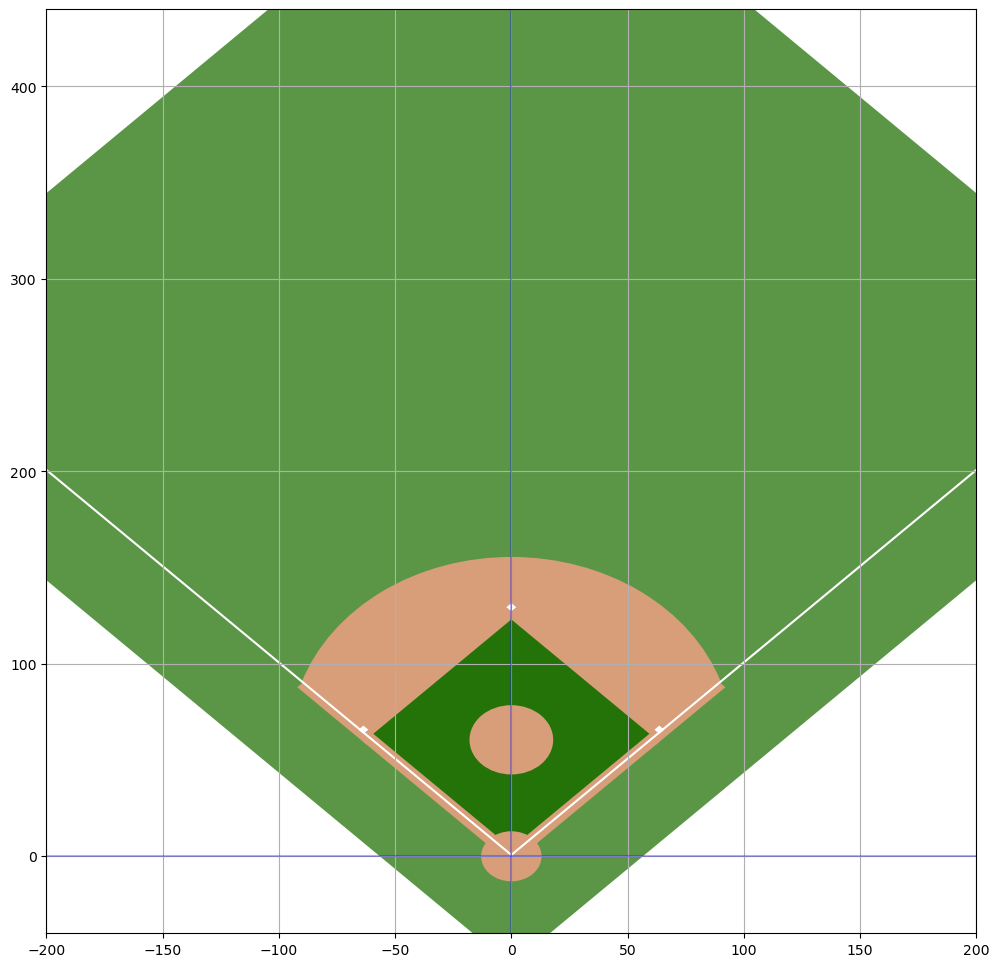

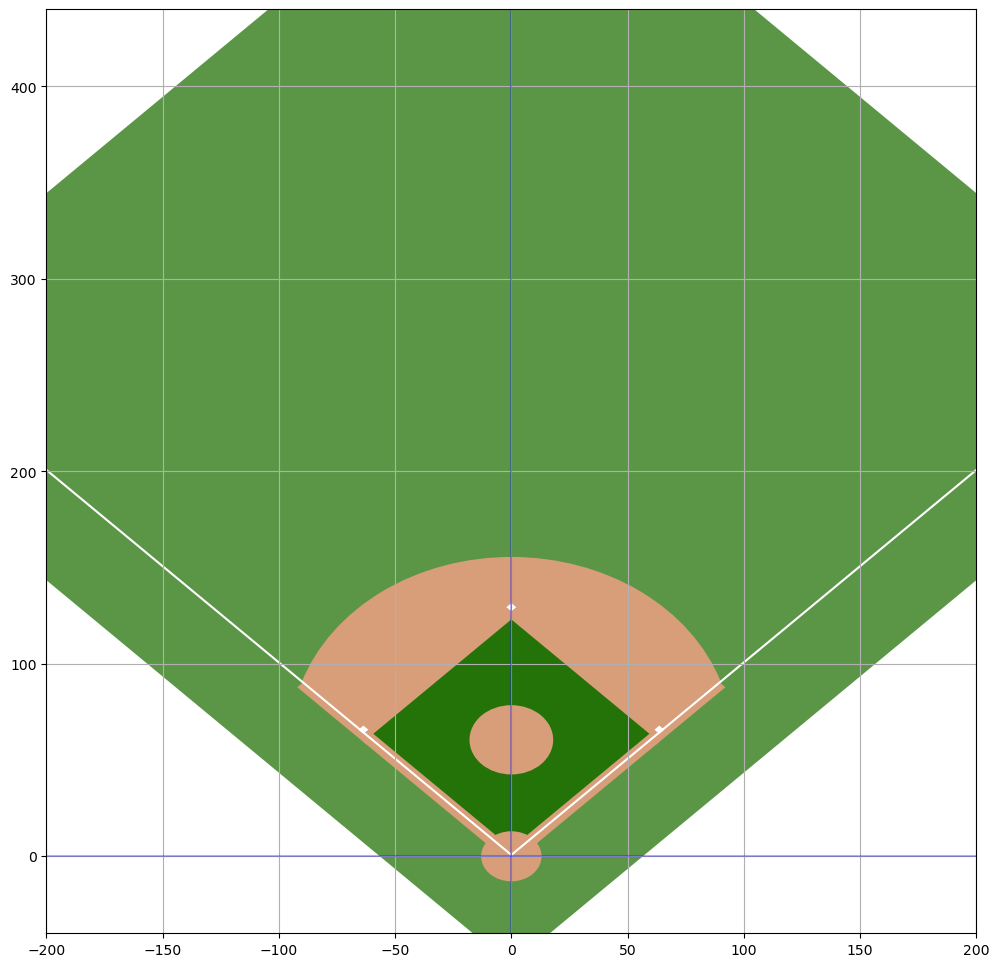

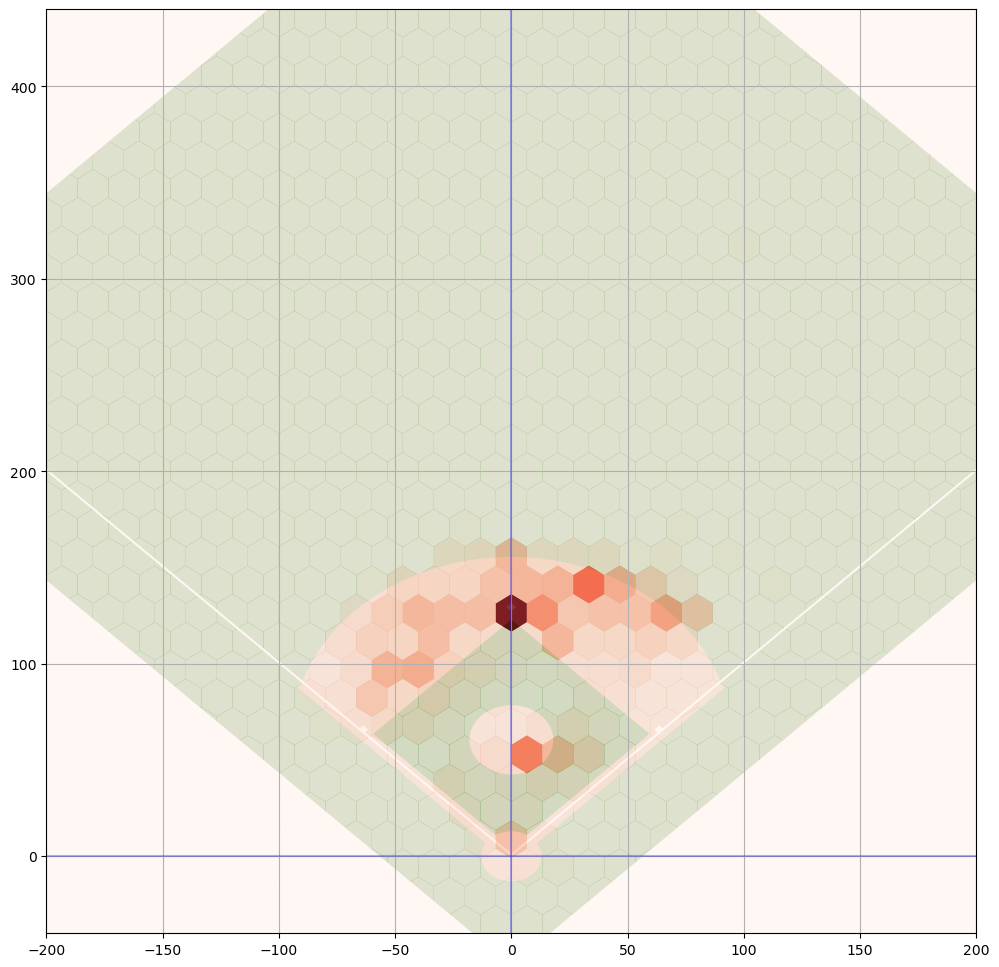

In [28]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(trusted_first_base_out["thrower_x"], 
             trusted_first_base_out["thrower_y"], 
             cmap="Reds", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()

#### Throws to first that were not outs

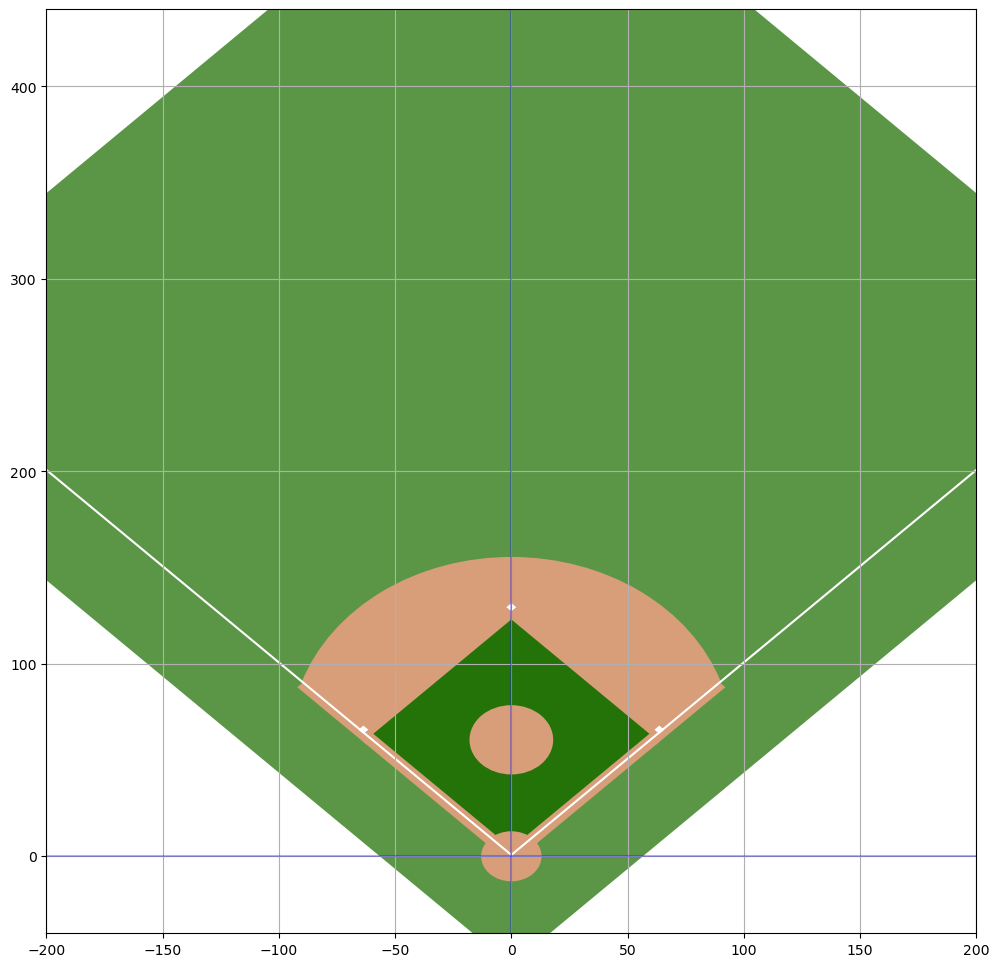

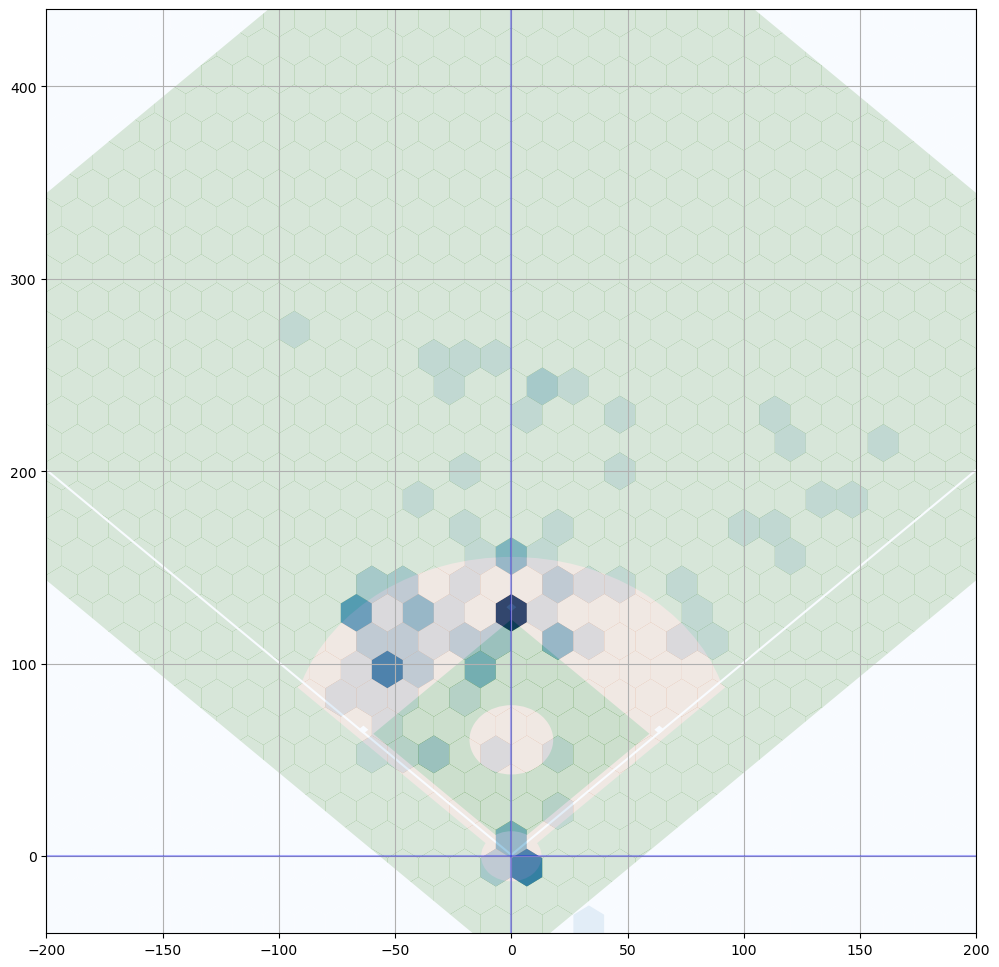

In [40]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(trusted_first_base_not_out["thrower_x"], 
             trusted_first_base_not_out["thrower_y"], 
             cmap="Blues", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()



### Batter plots


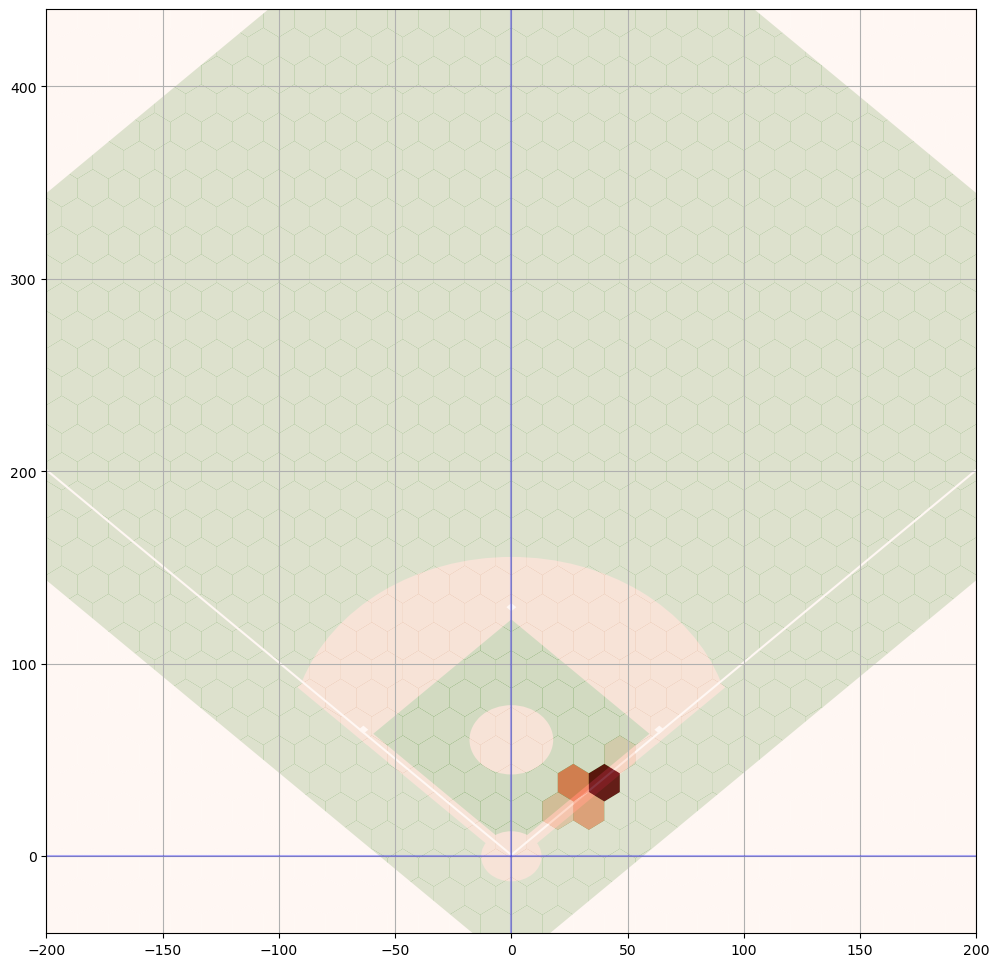

In [42]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(trusted_first_base_out["batter_x"], 
             trusted_first_base_out["batter_y"], 
             cmap="Reds", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()


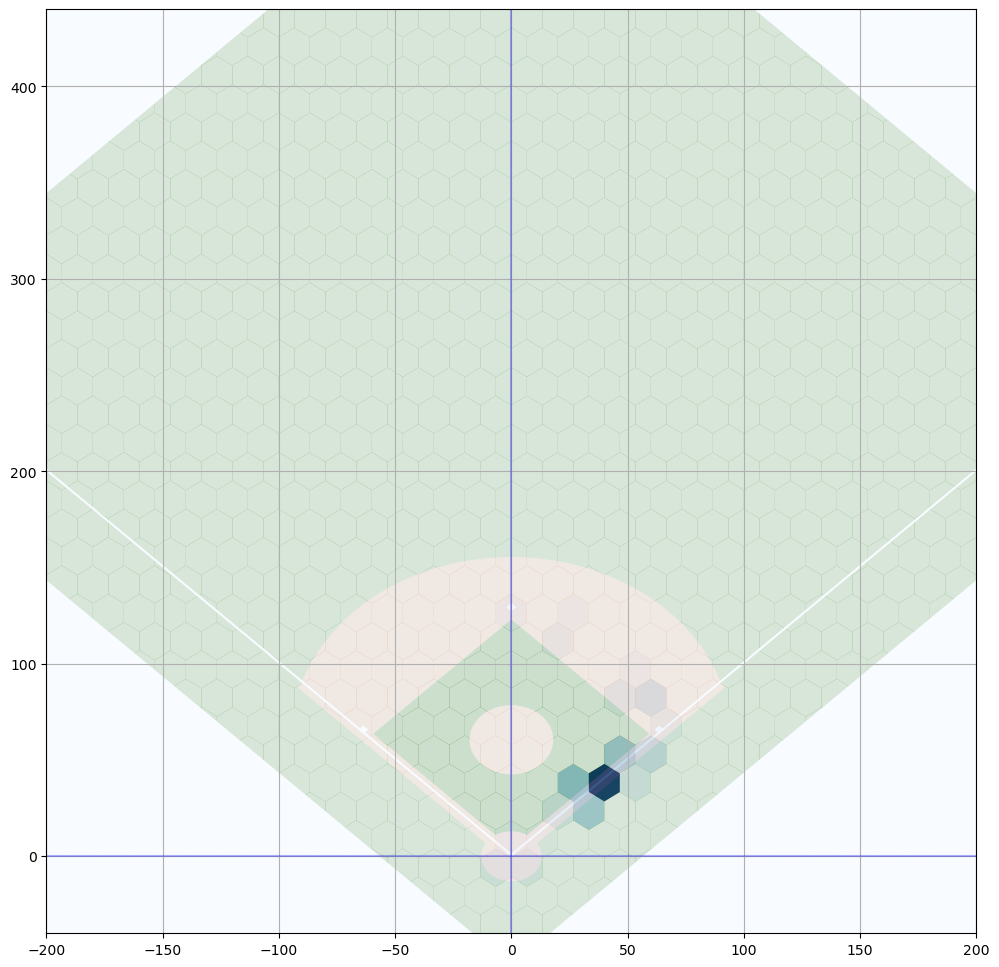

In [32]:
bf.clear_plot()

bf.fig, bf.ax = bf.plot_2d_field()

bf.ax.hexbin(trusted_first_base_not_out["batter_x"], 
             trusted_first_base_not_out["batter_y"], 
             cmap="Blues", 
             extent = ((-200, 200, -50, 450)),
             edgecolors=None,
             gridsize=30, 
             alpha=0.8) 

plt.show()


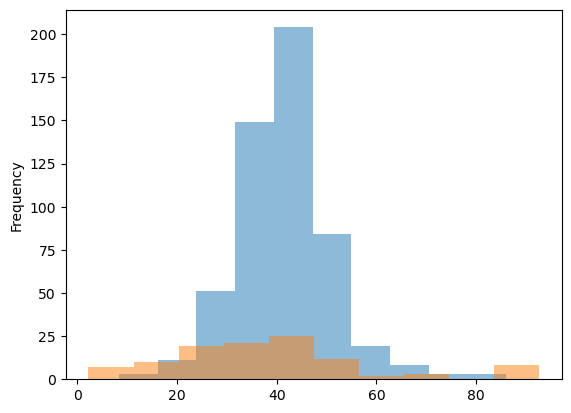

In [43]:
f, a  = plt.subplots()


trusted_first_base_out["batter_dist_to_first"].plot(kind="hist", alpha=0.5, ax=a)
trusted_first_base_not_out["batter_dist_to_first"].plot(kind="hist", alpha=0.5, ax=a)



plt.show()

In [115]:
f, a  = plt.subplots()

trusted_first_base_not_out["batter_dist_to_first"].plot(kind="hist", ax=a)


<Axes: ylabel='Frequency'>

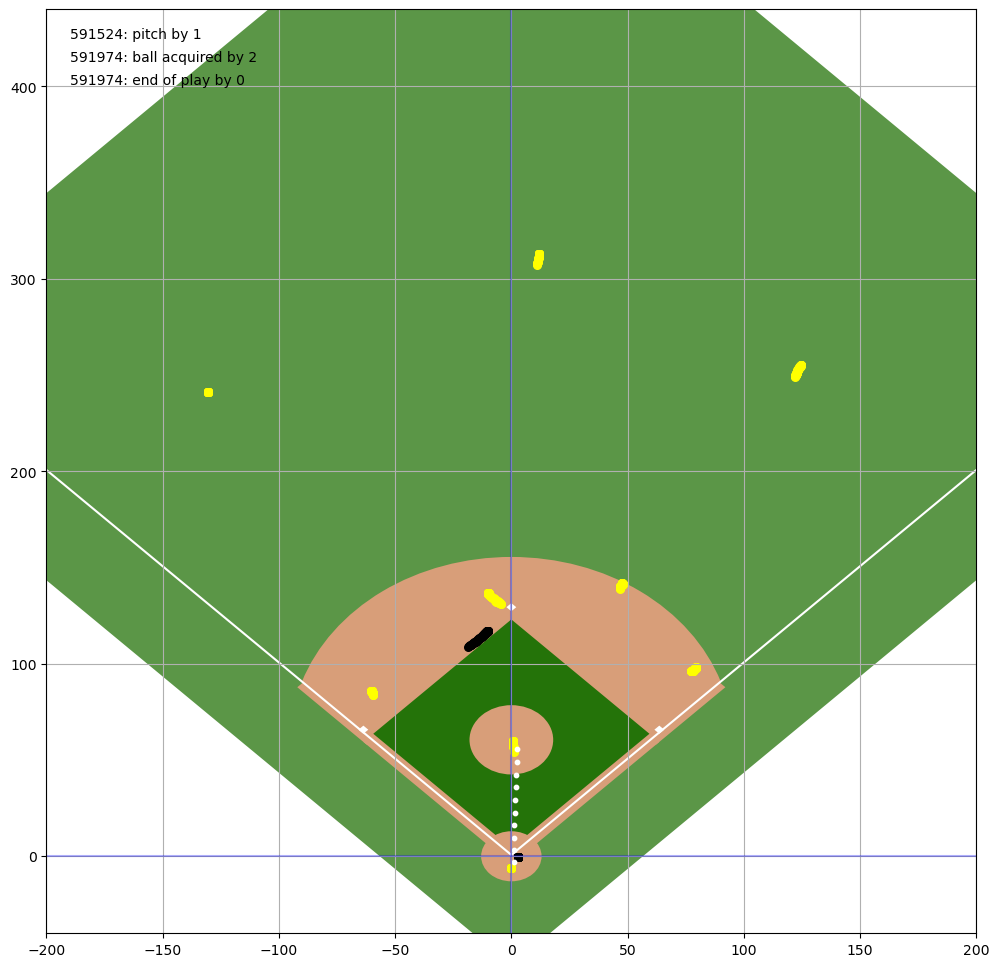

In [ ]:
bf.clear_plot()

play_id = 21# throws.loc[throws["xy_throw_angle"] < 5, :].play_id.iloc[1] # bf_1903_01.game_obj.get_pid_from_ppg(75)

bf.plot_all_components(play_id=play_id)
bf.fig

# bf.create_gif(play_id=play_id, tag="--throw_to_end_play")

## Try to build a Logistic Regression Model 

In [146]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from scipy.special import expit
from sklearn.calibration import CalibrationDisplay

from sklearn.metrics import (
    brier_score_loss,
    f1_score,
    log_loss,
    precision_score,
    recall_score,
    roc_auc_score,
)

In [161]:
model_dataset = pd.read_csv("model_dataset.csv", index_col=0)


trusted_first_base_out_throws = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_throws"]
trusted_first_base_out_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_receives"]


combined_outs = trusted_first_base_out_throws.merge(
    trusted_first_base_out_receives,
    on=["game_str", "play_id"],
    how="left",
    suffixes=["_throw", "_receive"]
)

combined_outs["target"] = 1


trusted_first_base_not_out_throws = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_throws"]
trusted_first_base_not_out_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_receives"]


combined_not_outs = trusted_first_base_not_out_throws.merge(
    trusted_first_base_not_out_receives,
    on=["game_str", "play_id"],
    how="left",
    suffixes=["_throw", "_receive"]
)


combined_not_outs["target"] = 0


train = pd.concat([combined_outs, combined_not_outs])

train = train.loc[:, ~train.columns.isin(['play_per_game'])]


In [162]:
train.head()

,game_str,play_per_game_throw,type_throw,play_id,player_id_throw,player_position_throw,xy_throw_angle_throw,elevation_throw_angle_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,ball_position_x_throw,ball_position_y_throw,ball_position_z_throw,play_per_game_receive,type_receive,player_id_receive,player_position_receive,xy_throw_angle_receive,elevation_throw_angle_receive,throw_velo_receive,batter_dist_to_first_receive,thrower_x_receive,thrower_y_receive,batter_x_receive,batter_y_receive,ball_position_x_receive,ball_position_y_receive,ball_position_z_receive,target
0,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,10.0,2053.0,4.0,1.962933,2.041084,73.227697,47.089984,0.6681,129.3444,29.2554,31.4652,2.444979,126.2148,5.65056,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,NaN,23.812321,NaN,NaN,45.9588,47.6892,61.6866,65.9577,2.751036,1
1,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,58.0,1972.0,6.0,2.358087,4.034777,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.535300,121.1655,5.69469,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,1
2,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,119.0,1972.0,6.0,2.914254,4.101199,74.823665,54.077160,-26.9574,141.8769,22.0485,29.0778,-24.595560,137.9598,5.61321,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,NaN,27.688541,NaN,NaN,43.5060,44.6319,61.2504,67.7586,3.642990,1
3,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,124.0,1972.0,6.0,2.987230,3.632922,65.831835,42.716782,7.1037,126.6021,33.9756,32.9025,9.726630,121.1817,5.34453,NaN,trusted_first_base_out_receives,2526.0,3.0,NaN,NaN,NaN,20.593925,NaN,NaN,48.9084,49.2486,63.9912,67.5339,4.300680,1
4,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,149.0,6993.0,4.0,0.596122,4.945087,62.531845,28.725288,-5.0850,116.7762,43.4148,43.2411,-6.311580,113.2134,6.00636,NaN,trusted_first_base_out_receives,5616.0,3.0,NaN,NaN,NaN,2.266255,NaN,NaN,61.6044,62.6427,58.8330,66.2850,4.709610,1


In [163]:
train.columns

Index(['game_str', 'play_per_game_throw', 'type_throw', 'play_id',
       'player_id_throw', 'player_position_throw', 'xy_throw_angle_throw',
       'elevation_throw_angle_throw', 'throw_velo_throw',
       'batter_dist_to_first_throw', 'thrower_x_throw', 'thrower_y_throw',
       'batter_x_throw', 'batter_y_throw', 'ball_position_x_throw',
       'ball_position_y_throw', 'ball_position_z_throw',
       'play_per_game_receive', 'type_receive', 'player_id_receive',
       'player_position_receive', 'xy_throw_angle_receive',
       'elevation_throw_angle_receive', 'throw_velo_receive',
       'batter_dist_to_first_receive', 'thrower_x_receive',
       'thrower_y_receive', 'batter_x_receive', 'batter_y_receive',
       'ball_position_x_receive', 'ball_position_y_receive',
       'ball_position_z_receive', 'target'],
      dtype='object')

In [174]:
cols_for_training =  ['xy_throw_angle_throw', 'elevation_throw_angle_throw',
       'throw_velo_throw', 'batter_dist_to_first_throw', 'thrower_x_throw',
       'thrower_y_throw', 'batter_x_throw', 'batter_y_throw'
       ]

#cols_for_training =  ['ball_position_x_receive', 'ball_position_y_receive', 'ball_position_z_receive', 'batter_y_receive']

In [206]:
X = train[cols_for_training].dropna()
y = train[cols_for_training + ["target"]].dropna()["target"]
player_ids = train[cols_for_training  + ["player_id_receive"]].dropna()["player_id_receive"]

game_strs = train[cols_for_training  + ["game_str"]].dropna()["game_str"]
play_ids = train[cols_for_training  + ["play_id"]].dropna()["play_id"]


In [207]:
clf = LogisticRegression(C=1e5)
clf.fit(X, y.values.ravel())

/Users/mattnicholson/anaconda3/envs/smt-data-challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(C=100000.0)

In [208]:
clf.coef_

array([[-0.28342809, -0.11513089, -0.05470613, -0.25823055,  0.00316243,
         0.0074845 , -0.26203179, -0.11698184]])

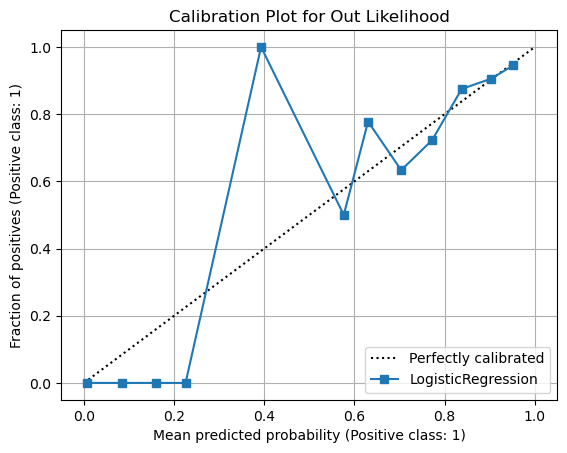

In [209]:
plt.close()

CalibrationDisplay.from_estimator(
    clf,
    X,
    y,
    n_bins = 15,
) 
plt.title("Calibration Plot for Out Likelihood")

plt.grid()
plt.show()

In [211]:
from collections import defaultdict
scores = defaultdict(list)

clf.fit(X, y)
y_prob = clf.predict_proba(X)
y_pred = clf.predict(X)

for metric in [brier_score_loss, log_loss, roc_auc_score]:
        score_name = metric.__name__.replace("_", " ").replace("score", "").capitalize()
        scores[score_name].append(metric(y, y_prob[:, 1]))

/Users/mattnicholson/anaconda3/envs/smt-data-challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [212]:
pd.DataFrame(scores)

,Brier loss,Log loss,Roc auc
0,0.102556,0.347781,0.768285


### Do the prediction and compute the "scores" for each player, with the n

In [216]:
full_data = X

clf.fit(X, y)


full_data["predicted_prob"] = clf.predict_proba(X)[:, 1]
full_data["target"] = y
full_data["receiver_id"] = player_ids
full_data["game_str"] = game_strs
full_data["play_id"] = play_ids




full_data["scoops_scores"] = X.apply(
    lambda row: row["target"] * 1 - row["predicted_prob"], 
    axis = 1
)


/Users/mattnicholson/anaconda3/envs/smt-data-challenge/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [218]:
full_data.sort_values(by="scoops_scores")

,xy_throw_angle_throw,elevation_throw_angle_throw,throw_velo_throw,batter_dist_to_first_throw,thrower_x_throw,thrower_y_throw,batter_x_throw,batter_y_throw,predicted_prob,target,receiver_id,game_str,play_id,scoops_scores
90,1.544462,0.639823,49.802593,28.954388,84.2532,106.5036,43.0053,43.3275,0.974408,0,1923.0,1901_16_TeamLH_TeamA3,214.0,-0.974408
61,0.710697,4.128031,53.593847,33.123616,75.9009,122.3115,40.6902,39.7545,0.964660,0,5921.0,1902_14_TeamMK_TeamB,113.0,-0.964660
95,0.281580,7.345730,51.570897,34.398492,27.8742,113.0877,38.7501,39.8958,0.957316,0,2480.0,1902_17_TeamMB_TeamA1,38.0,-0.957316
92,0.656195,1.928326,59.536901,24.433444,26.2269,107.7183,45.8403,46.9011,0.954461,0,2044.0,1902_25_TeamMH_TeamA3,122.0,-0.954461
28,0.535982,6.097158,59.629552,46.709605,23.7825,139.7472,30.5766,30.6453,0.951313,0,4088.0,1901_07_TeamLK_TeamB,54.0,-0.951313
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
337,3.989086,2.782084,81.698570,38.074916,-57.6117,82.2969,36.2553,37.1859,0.612375,1,8151.0,1902_06_TeamML_TeamB,22.0,0.387625
364,6.740472,1.007547,67.917820,31.082339,11.1273,25.6590,41.2320,42.0987,0.588094,1,2227.0,1901_14_TeamLL_TeamB,7.0,0.411906
195,7.418955,2.233167,73.630919,42.923713,-26.8734,114.6201,33.2400,33.3360,0.578648,1,1980.0,1903_09_TeamNJ_TeamB,15.0,0.421352
248,10.850935,3.012597,48.603437,20.616463,27.5025,37.3272,47.5719,50.7219,0.546999,1,2480.0,1902_24_TeamMA_TeamA1,5.0,0.453001


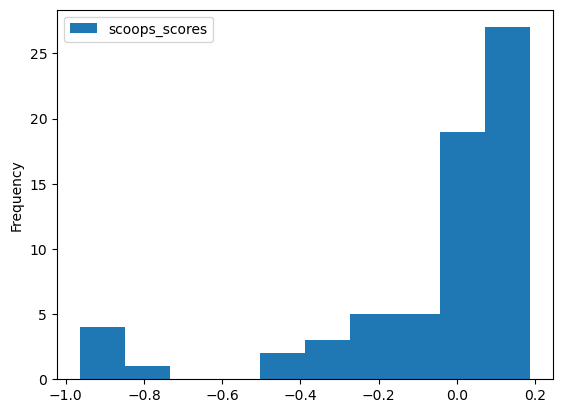

In [239]:
# can slice this up a bunch of different ways
# - by year, by player, by level, etc

cols = ["receiver_id", "scoops_scores"]

full_data[cols].groupby("receiver_id").mean().plot(kind="hist")

plt.show()

## Something is wrong with these labels, but explore some plays

In [240]:
bf = Baseball_Field("1902_14_TeamMK_TeamB")

In [242]:
bf.clear_plot()

play_id = 113 

#bf.plot_all_components(play_id=play_id)
#bf.fig


bf.create_gif(play_id=play_id, tag="--likely out")

MovieWriter ffmpeg unavailable; using Pillow instead.


## Make a 3D plot of where the balls ended up!

### Where the balls were received

In [126]:
trusted_first_base_out

,game_str,play_per_game,type,play_id,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z,target
10,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,10.0,1.962933,2.041084,73.227697,47.089984,0.6681,129.3444,29.2554,31.4652,2.444979,126.21480,5.650560,1
58,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,58.0,2.358087,4.034777,72.686062,51.954068,-39.4440,125.9001,26.6307,27.1764,-35.535300,121.16550,5.694690,1
119,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,119.0,2.914254,4.101199,74.823665,54.077160,-26.9574,141.8769,22.0485,29.0778,-24.595560,137.95980,5.613210,1
124,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,124.0,2.987230,3.632922,65.831835,42.716782,7.1037,126.6021,33.9756,32.9025,9.726630,121.18170,5.344530,1
149,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_throws,149.0,0.596122,4.945087,62.531845,28.725288,-5.0850,116.7762,43.4148,43.2411,-6.311580,113.21340,6.006360,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,188.0,0.552094,3.544626,64.710995,36.947705,14.7525,130.4877,38.6280,36.4449,14.963610,125.74440,4.365840,1
198,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,198.0,3.109739,15.644901,31.369518,26.362099,37.2222,45.7701,44.6925,45.3102,38.319000,47.28210,1.404567,1
203,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,203.0,0.339133,9.081065,52.311022,45.035599,56.2413,129.7479,31.5411,32.0502,53.201700,129.83460,3.536160,1
245,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_throws,245.0,1.785634,3.350765,73.563723,42.896724,-19.9359,151.5210,33.9753,32.6532,-19.631610,149.19000,5.596620,1


In [128]:
model_dataset["type"].unique()

array(['trusted_out', 'trusted_first_base_out_throws',
       'trusted_first_base_out_recieves',
       'trusted_first_base_not_out_throws', 'trusted_double_play'],
      dtype=object)

In [129]:
trusted_first_base_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_receives"]
trusted_first_base_receives["target"] = 1

In [130]:
trusted_first_base_receives

,game_str,play_per_game,type,play_id,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z,target
35,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_recieves,10.0,NaN,NaN,NaN,23.812321,NaN,NaN,45.9588,47.6892,61.6866,65.9577,2.751036,1
181,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_recieves,48.0,NaN,NaN,NaN,5.415868,NaN,NaN,61.8519,58.5273,98.3451,97.2681,5.771700,1
216,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_recieves,58.0,NaN,NaN,NaN,23.276346,NaN,NaN,47.2962,47.0661,59.6838,65.3253,2.773476,1
455,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_recieves,119.0,NaN,NaN,NaN,27.688541,NaN,NaN,43.5060,44.6319,61.2504,67.7586,3.642990,1
484,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_out_recieves,124.0,NaN,NaN,NaN,20.593925,NaN,NaN,48.9084,49.2486,63.9912,67.5339,4.300680,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_recieves,188.0,NaN,NaN,NaN,13.423730,NaN,NaN,54.1467,54.1485,61.4487,65.7189,2.347149,1
686,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_recieves,198.0,NaN,NaN,NaN,8.204738,NaN,NaN,57.3195,58.4076,59.3292,65.7147,4.946880,1
707,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_recieves,203.0,NaN,NaN,NaN,24.394698,NaN,NaN,46.1169,46.6674,63.2970,65.1057,5.985390,1
852,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_out_recieves,245.0,NaN,NaN,NaN,17.202228,NaN,NaN,51.4695,51.4821,60.3270,68.0484,2.670495,1


In [217]:
trusted_first_base_receives = model_dataset.loc[model_dataset["type"] == "trusted_first_base_out_receives"]


In [218]:
trusted_first_base_receives_not_outs = model_dataset.loc[model_dataset["type"] == "trusted_first_base_not_out_receives"]

In [219]:
trusted_first_base_receives_not_outs

,game_str,play_per_game,type,play_id,xy_throw_angle,elevation_throw_angle,throw_velo,batter_dist_to_first,thrower_x,thrower_y,batter_x,batter_y,ball_position_x,ball_position_y,ball_position_z
542,1903_01_TeamNE_TeamA2,NaN,trusted_first_base_not_out_receives,136.0,NaN,NaN,NaN,87.755115,NaN,NaN,2.5248,0.6639,57.420900,61.7751,3.735570
658,1903_16_TeamNI_TeamA3,NaN,trusted_first_base_not_out_receives,162.0,NaN,NaN,NaN,2.910815,NaN,NaN,60.7692,63.1563,60.861300,67.8513,-1.542582
149,1902_02_TeamMG_TeamA3,NaN,trusted_first_base_not_out_receives,44.0,NaN,NaN,NaN,94.586580,NaN,NaN,-6.2472,127.3770,55.530300,142.1634,0.452622
1211,1902_02_TeamMG_TeamA3,NaN,trusted_first_base_not_out_receives,339.0,NaN,NaN,NaN,37.558614,NaN,NaN,37.5030,36.6669,24.251700,91.7796,0.000000
340,1903_08_TeamNJ_TeamB,NaN,trusted_first_base_not_out_receives,90.0,NaN,NaN,NaN,3.609238,NaN,NaN,60.6081,61.6809,64.012800,70.2018,3.706350
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
144,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_receives,38.0,NaN,NaN,NaN,13.036025,NaN,NaN,53.3625,55.6197,63.756000,63.3762,3.834150
281,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_receives,78.0,NaN,NaN,NaN,89.209279,NaN,NaN,-1.0044,2.1624,54.129600,101.2713,7.114380
865,1901_15_TeamLL_TeamB,NaN,trusted_first_base_not_out_receives,237.0,NaN,NaN,NaN,19.564819,NaN,NaN,48.5805,51.1494,61.237200,66.3597,4.883250
998,1902_31_TeamMF_TeamA2,NaN,trusted_first_base_not_out_receives,287.0,NaN,NaN,NaN,3.817707,NaN,NaN,61.3140,60.6120,58.423500,66.6582,2.338893


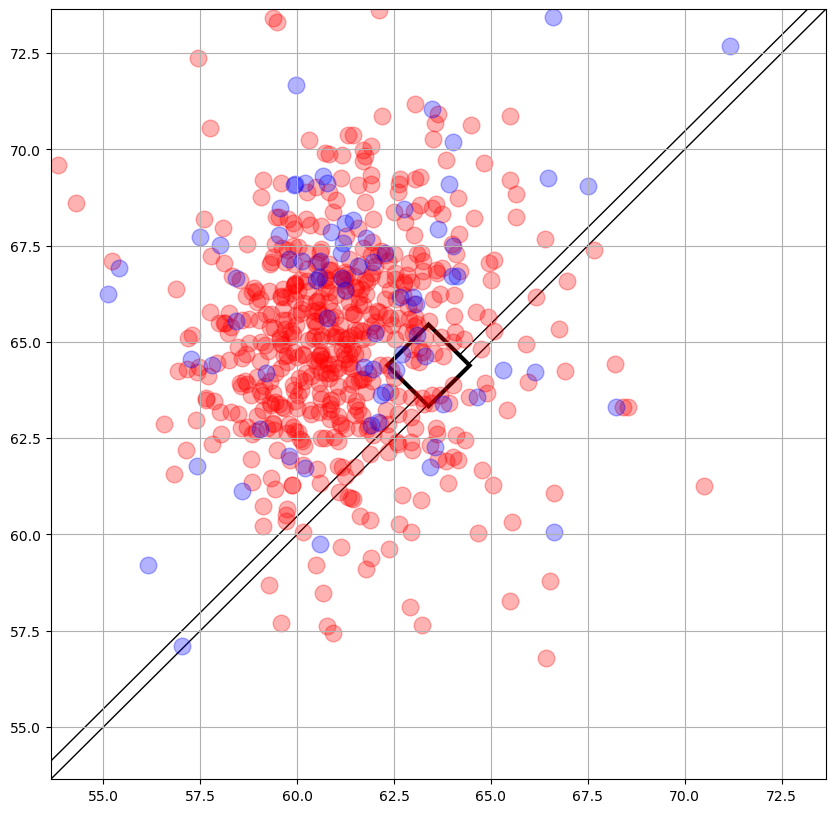

In [241]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

first_base_point = [63.63961031, 63.63961031]

first_baseline = Rectangle(
    (0, 0), 
    300, 
    1/3,
    edgecolor = 'black',
    facecolor="white",
    angle=45,
    rotation_point = (0, 0)
)

ax.add_patch(first_baseline)

first_base = Rectangle(
    [63.63961031 - (1), 63.63961031], 1.5, 1.5,
    edgecolor = 'black',
    facecolor = "white",
    rotation_point="center",
    angle=45,
    fill=True,
    lw=3
)

ax.add_patch(first_base)

ax.scatter(
    trusted_first_base_receives["ball_position_x"], 
    trusted_first_base_receives["ball_position_y"], 
#    trusted_first_base_receives["ball_position_z"], 
    alpha=0.3,
    marker='o',
    s=12 ** 2,
    color="red"
)


ax.scatter(
    trusted_first_base_receives_not_outs["ball_position_x"], 
    trusted_first_base_receives_not_outs["ball_position_y"], 
#    trusted_first_base_receives["ball_position_z"], 
    alpha=0.3,
    marker='o',
    s=12 ** 2,
    color="blue"
)


ax.set_xlim(first_base_point[0] - 10, first_base_point[0] + 10)
ax.set_ylim(first_base_point[1] - 10, first_base_point[1] + 10)

plt.grid()

plt.show()

### Try again with a hexbin and a mean

In [243]:
trusted_first_base_receives["target"] = 1
trusted_first_base_receives_not_outs["target"] = 0

hex_plotting = pd.concat([trusted_first_base_receives, trusted_first_base_receives_not_outs])

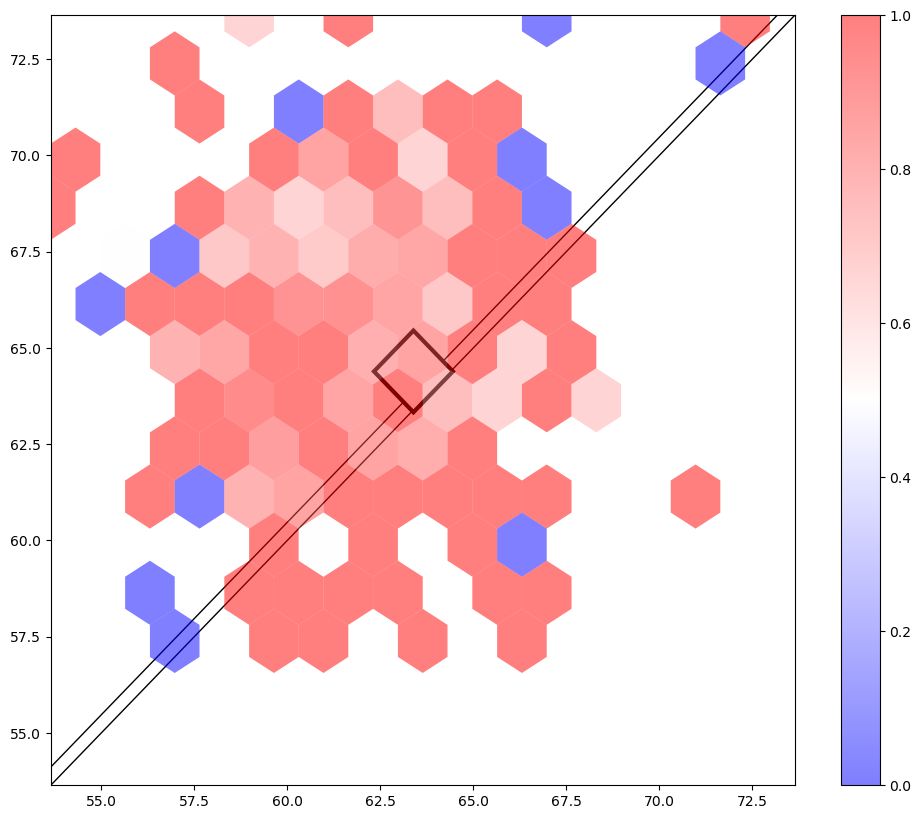

In [261]:
fig = plt.figure(figsize=(12,10))
ax = fig.add_subplot()

first_base_point = [63.63961031, 63.63961031]

first_baseline = Rectangle(
    (0, 0), 
    300, 
    1/3,
    edgecolor = 'black',
    facecolor="white",
    angle=45,
    rotation_point = (0, 0)
)

ax.add_patch(first_baseline)

first_base = Rectangle(
    [63.63961031 - (1), 63.63961031], 1.5, 1.5,
    edgecolor = 'black',
    facecolor = "white",
    rotation_point="center",
    angle=45,
    fill=True,
    lw=3
)

ax.add_patch(first_base)

im = ax.hexbin(hex_plotting["ball_position_x"], 
          hex_plotting["ball_position_y"], 
          C = hex_plotting["target"],
          cmap="bwr", 
          extent = ((first_base_point[0] - 10, first_base_point[0] + 10, first_base_point[1] - 10, first_base_point[1] + 10)),
          edgecolors=None,
          gridsize=15, 
          alpha=0.5) 


ax.set_xlim(first_base_point[0] - 10, first_base_point[0] + 10)
ax.set_ylim(first_base_point[1] - 10, first_base_point[1] + 10)

fig.colorbar(im)

# plt.grid()

plt.show()

### IDK WHY THIS 3D STUFF ISN'T WORKING

In [142]:
from mpl_toolkits import mplot3d
import mpl_toolkits.mplot3d.art3d as art3d
from matplotlib.patches import Polygon, Rectangle

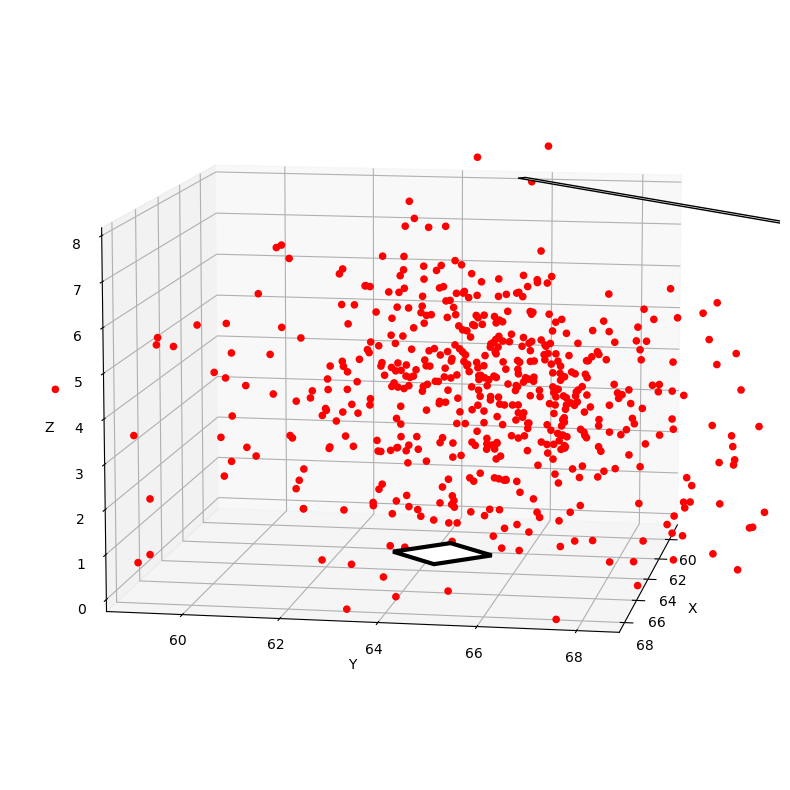

In [237]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')

ax.scatter(
    trusted_first_base_receives["ball_position_x"], 
    trusted_first_base_receives["ball_position_y"], 
    trusted_first_base_receives["ball_position_z"], 
    alpha=1,
    marker='o',
    color = "red"
)

first_base_point = [63.63961031, 63.63961031]

first_base_line = Rectangle(
    (40, 40), 
    30, 
    1/3,
    edgecolor = 'black',
    facecolor= "white",
    angle=45,
    rotation_point = (0, 0)
)

ax.add_patch(first_base_line)

art3d.pathpatch_2d_to_3d(
    first_base_line, 
    z=0, 
    zdir="z"
)


first_base = Rectangle(
    [63.63961031 - (1), 63.63961031], 1.5, 1.5,
    edgecolor = 'black',
    facecolor = "white",
    rotation_point="center",
    angle=45,
    fill=True,
    lw=3
)

ax.add_patch(first_base)

art3d.pathpatch_2d_to_3d(
    first_base, 
    z=0, 
    zdir="z"
)

ax.set_xlim(first_base_point[0] - 5, first_base_point[0] + 5)
ax.set_ylim(first_base_point[1] - 5, first_base_point[1] + 5)
ax.set_zlim(-0.1, 8)


ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_aspect("equalxy")

ax.elev = 10 # 3 is roughly Center field camera angle
ax.azim = 10  # xy view 10 is over right shoulder

plt.show()

### Where the balls landed when thrown?
- This would be the same as before, but for all the plays where the ball bounced, use that coord instead and the ball acquired one!